# ensemble of Gantt charts

In [1]:
import pandas
print(pandas.__version__)
import matplotlib.pyplot as plt
import matplotlib
print(matplotlib. __version__)
import datetime
import random
import time
import pickle
import sys
print(sys.version)

1.3.3
3.4.3
3.9.6 | packaged by conda-forge | (default, Jul 11 2021, 03:39:48) 
[GCC 9.3.0]


In [2]:
# https://wiki.python.org/moin/UsingPickle

with open("project.pkl", "rb") as file_handle:
    df = pickle.load( file_handle )

In [3]:
df

,ID,Duration in days,predecessor ID,successor ID,predecessor category,successor category,predecessor change in days,successor change in days
0,1,5,NaN,2,NaN,NaN,NaN,23.0
0,1,5,NaN,3,NaN,start-to-finish,NaN,8.0
1,2,12,5,4,NaN,NaN,NaN,NaN
2,3,6,4,NaN,finish-to-start,NaN,20.0,NaN
3,4,10,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# https://towardsdatascience.com/create-new-column-based-on-other-columns-pandas-5586d87de73d

def set_max(row, max_min_task_dict):
    return int(row['Duration in days'])+max_min_task_dict[row['ID']][1]
    
def set_min(row, max_min_task_dict):
    """
    if initial value is zero we don't want to decrease that
    """
    return max(int(row['Duration in days'])-max_min_task_dict[row['ID']][0], 0)

In [5]:
# the error is per task, not per row
# create a lookup table of per-task errors

max_min_task_dict = {}
for task_id in df['ID'].unique():
                                    # subtract by          # add to
    max_min_task_dict[task_id] = (random.randrange(1,3), random.randrange(1,3))

In [6]:
# use the lookup table to add two columns

df['Duration min'] = df.apply(lambda row: set_min(row, max_min_task_dict), axis=1)
df['Duration max'] = df.apply(lambda row: set_max(row, max_min_task_dict), axis=1)

In [7]:
df

,ID,Duration in days,predecessor ID,successor ID,predecessor category,successor category,predecessor change in days,successor change in days,Duration min,Duration max
0,1,5,NaN,2,NaN,NaN,NaN,23.0,3,7
0,1,5,NaN,3,NaN,start-to-finish,NaN,8.0,3,7
1,2,12,5,4,NaN,NaN,NaN,NaN,10,13
2,3,6,4,NaN,finish-to-start,NaN,20.0,NaN,4,7
3,4,10,NaN,NaN,NaN,NaN,NaN,NaN,8,11


## loop over instances of schedule

In [8]:
def pick_actual_duration(row, actual_task_duration_dict):
    return actual_task_duration_dict[row['ID']]

def calculate_end_date(row):
    return row['Duration actual in days']+row['actual start day index']

In [9]:
# need a "first task" from which everything else off-sets
initial_task_ID = 1 

# this could be determined by date if those were present

initial_task_start_day_index = 0

In [10]:
durations_list = []

start_time = time.time()

for instance_index in range(100):
    actual_task_duration_dict = {}
    for task_id in df['ID'].unique():
        max_duration_this_task = df[df['ID']==task_id]['Duration max'].values[0]
        min_duration_this_task = df[df['ID']==task_id]['Duration min'].values[0]

        actual_task_duration_dict[task_id] = random.randrange(min_duration_this_task,max_duration_this_task)

    df['Duration actual in days'] = df.apply(lambda row: pick_actual_duration(row, actual_task_duration_dict), axis=1)

    #**************

    # create new column to track actual start day
    # initialize to invalid value

    df['actual start day index'] = -1

    # https://stackoverflow.com/a/19226617/1164295
    df.loc[df['ID'] == initial_task_ID, 'actual start day index'] = initial_task_start_day_index

    #****************

    for task_ID in df['ID'].unique():

        #print("task ID =",task_ID)
        for successor_id in df[df['ID']==task_ID]['successor ID'].values:
            #print("  successor ID = ", successor_id)

            # https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.notnull.html
            if pandas.notna(successor_id): # has successor
                relative_day_that_successor_starts = df[(df['ID']==task_ID) & (df['successor ID']==successor_id)]['Duration actual in days'].values[0]
                day_that_successor_starts = relative_day_that_successor_starts+df[(df['ID']==task_ID) & (df['successor ID']==successor_id)]['actual start day index'].values[0]
                #print("    which starts on day ", day_that_successor_starts,"\n")

                df.loc[df['ID'] == int(successor_id), 'actual start day index'] = day_that_successor_starts

    #**************

    df['actual end day index'] = df.apply(lambda row: calculate_end_date(row), axis=1)

    duration_of_effort_in_days = df['actual end day index'].max()
    
    durations_list.append(duration_of_effort_in_days)
    
    if instance_index%5==0:
        print("loop",instance_index,"elapsed",round(time.time()-start_time,1),'seconds')

loop 0 elapsed 0.1 seconds
loop 5 elapsed 0.2 seconds
loop 10 elapsed 0.4 seconds
loop 15 elapsed 0.5 seconds
loop 20 elapsed 0.7 seconds
loop 25 elapsed 0.9 seconds
loop 30 elapsed 1.0 seconds
loop 35 elapsed 1.2 seconds
loop 40 elapsed 1.3 seconds
loop 45 elapsed 1.4 seconds
loop 50 elapsed 1.6 seconds
loop 55 elapsed 1.8 seconds
loop 60 elapsed 1.9 seconds
loop 65 elapsed 2.0 seconds
loop 70 elapsed 2.2 seconds
loop 75 elapsed 2.4 seconds
loop 80 elapsed 2.5 seconds
loop 85 elapsed 2.7 seconds
loop 90 elapsed 2.8 seconds
loop 95 elapsed 2.9 seconds


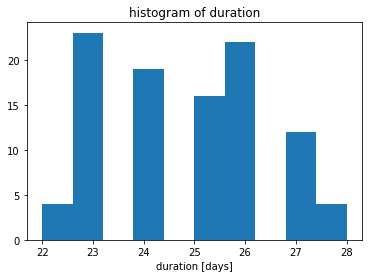

In [11]:
plt.hist(durations_list)
plt.xlabel('duration [days]')
plt.title('histogram of duration');